In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Change Dataset for RNN
#### we now need to Convert: ["emma", "olivia", "ava", ...]

into tensors like:

X: [[e, m, m, a],
    [o, l, i, v, i, a],
    [a, v, a], ...]

Y: shifted version (next char targets)

## A little bit change in the Token Mapping
I'll use:
- 0 to denote ---> <PAD> tokens
- 1 to denote ---> '.' (end token)
- and all characters from [2, .., 28]

In [2]:
# Load all the words from the '.txt' file
words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()

# Encoder and Decoder
# A little bit change in the Token Mapping
# I'll use:
# - 0 to denote ---> <PAD> tokens
# - 1 to denote ---> '.' (end token)
# - and all characters from [2, .., 28]

chars = sorted(list(set(''.join(words))))

# Reserve 0 for PAD token
stoi = {c: i+2 for i, c in enumerate(chars)}  # alphabet starts at index 2
stoi['.'] = 1   # END token
stoi['<PAD>'] = 0   # padding token
itos = {i: c for c, i in stoi.items()}

def encode_word(word, stoi):
    return [stoi[c] for c in word] + [stoi['.']]

def decode_indices(indices, itos):
    return [itos[i.item()] for i in indices]

encoded = [encode_word(w, stoi) for w in words]
max_len = max(len(seq) for seq in encoded)

def pad_sequences(sequences, max_len):
    X, Y = [], []

    for seq in sequences:
        x = seq[:-1]                        # all but last char
        y = seq[1:]                         # all but first char

        # padding
        x += [0] * (max_len - len(x))
        y += [-100] * (max_len - len(y))

        X.append(x)
        Y.append(y)

    return torch.tensor(X), torch.tensor(Y)

def generate_dataset():
    words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()
    encoded = [encode_word(w, stoi) for w in words]
    max_len = max(len(seq) for seq in encoded)
    x_tensor, y_tensor = pad_sequences(encoded, max_len)
    return x_tensor, y_tensor

In [3]:
x_train, y_train = generate_dataset()

In [4]:
class Embeddings:
    def __init__(self, embd_dim, n_classes):
        self.embd_dim = embd_dim
        self.n_classes = n_classes
        self.embd_matrix = torch.nn.Parameter(torch.randn(self.n_classes, self.embd_dim, requires_grad=True))
    
    def forward(self, x):
        return self.embd_matrix[x]
    
    def parameters(self):
        return [self.embd_matrix]
    
    def __call__(self, x):
        return self.forward(x)
    
    def to(self, device):
        self.embd_matrix = torch.nn.Parameter(self.embd_matrix.to(device))
        return self
    
    def named_parameters(self, prefix="embeddings"):
        return {f"{prefix}.embd_matrix": self.embd_matrix}


class Linear:
    def __init__(self, *, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features))
        self.bias = torch.nn.Parameter(torch.randn(out_features,))
    
    def forward(self, x):
        return x @ self.weight + self.bias
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return [self.weight] + [self.bias]
    
    def to(self, device):
        self.weight = torch.nn.Parameter(self.weight.to(device))
        self.bias = torch.nn.Parameter(self.bias.to(device))
        return self
    
    def named_parameters(self, prefix="linear"):
        return {
            f"{prefix}.weight": self.weight,
            f"{prefix}.bias": self.bias
        }

class RNN_cell:
    def __init__(self, embd_dim, hidden_dim, n_classes = None, name="rnn_cell"):
        self.name = name
        self.weight_x = torch.nn.Parameter(torch.randn(embd_dim, hidden_dim))
        self.weight_h = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bias_h = torch.nn.Parameter(torch.randn(hidden_dim))

        # Tanh-saturation solution: Reduces saturation and improves learnability
        torch.nn.init.xavier_uniform_(self.weight_x)
        torch.nn.init.orthogonal_(self.weight_h)
        torch.nn.init.zeros_(self.bias_h)

        self.return_logits = (n_classes is not None)
        self.layer_norm = LayerNorm1d()
        if self.return_logits:
            self.weight_y = torch.nn.Parameter(torch.randn(hidden_dim, n_classes))
            torch.nn.init.xavier_uniform_(self.weight_y)
            self.bias_y = torch.nn.Parameter(torch.randn(n_classes))
            torch.nn.init.zeros_(self.bias_y)
    
    def forward(self, x, h_prev):
        pre_act = x @ self.weight_x + h_prev @ self.weight_h + self.bias_h
        norm_pre_act = self.layer_norm(pre_act) # norm_pre_act = Normalized Pre-activations
        h_raw = torch.tanh(norm_pre_act)
        h = 0.5 * (h_prev + h_raw) # Residual scaled skip connection
        # Problem: Vanishing gradient when stacking layers, Solution: Residual skip connection (0.5 scaling)
        if self.return_logits:
            y = h @ self.weight_y + self.bias_y
            return h, y
        return h
    
    def __call__(self, x, h_prev): 
        return self.forward(x, h_prev)
    
    def parameters(self):
        params = [self.weight_x, self.weight_h, self.bias_h]
        if self.return_logits:
            params += [self.weight_y, self.bias_y]
        return params
    
    def to(self, device):
        self.weight_x = torch.nn.Parameter(self.weight_x.to(device))
        self.weight_h = torch.nn.Parameter(self.weight_h.to(device))
        self.bias_h   = torch.nn.Parameter(self.bias_h.to(device))
        if self.return_logits:
            self.weight_y = torch.nn.Parameter(self.weight_y.to(device))
            self.bias_y   = torch.nn.Parameter(self.bias_y.to(device))
        return self
    
    def named_parameters(self, prefix=None):
        name = prefix or self.name
        params = {
            f"{name}.weight_x": self.weight_x,
            f"{name}.weight_h": self.weight_h,
            f"{name}.bias_h": self.bias_h,
        }
        # layer norm params
        ln_params = self.layer_norm.named_parameters(prefix=f"{name}.layer_norm")
        params.update(ln_params)
        if self.return_logits:
            params[f"{name}.weight_y"] = self.weight_y
            params[f"{name}.bias_y"]   = self.bias_y
        return params

class RNNLayer:
    def __init__(self, embd_dim, hidden_dim, n_classes = None, name="rnn_layer"):
        self.name = name
        self.rnn_cell = RNN_cell(embd_dim, hidden_dim, n_classes)
        self.return_logits = (n_classes is not None)
    
    def forward(self, x, prev_hidden = None):
        # x.shape = (batch_size, block_size, embd_dim) --> (2, 8, 15)
        batch_size, block_size, _ = x.shape
        device = x.device

        if prev_hidden is None:
            prev_hidden = torch.zeros(batch_size, self.rnn_cell.weight_h.shape[0]).to(device)
        
        hidden_states = []
        outputs = []
        h = prev_hidden
        for t in range(block_size):
            x_t = x[:, t, :]
            output = self.rnn_cell(x_t, h)
            if self.return_logits:
                h, y = output
                outputs.append(y) # here y.shape = (batch_size, n_classes)
            else:
                h = output
            
            hidden_states.append(h)
            
        
        # Convert list --> tensor format: (batch, block_size, dim) --> for each example in a batch we now computed hidden_states and outputs for each character in a block_size (at each timesetp)
        hidden_states = torch.stack(hidden_states, dim=1)
        if self.return_logits:
            outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, n_classes)
            return hidden_states, outputs
        
        return hidden_states
    
    def __call__(self, x, h_prev=None):
        return self.forward(x, h_prev)
    
    def parameters(self):
        return self.rnn_cell.parameters()
    
    def to(self, device):
        self.rnn_cell.to(device)
        return self
    
    def named_parameters(self, prefix=None):
        name = prefix or self.name
        return self.rnn_cell.named_parameters(prefix=f"{name}.cell")


class Flatten:
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self


class Sequential:
    def __init__(self, layers):
        self.layers = layers
        # Model Configuration
        self.embd_dim = None
        self.n_classes = None
        self.in_features = None
        self.out_features = None
        for layer in self.layers:
            if isinstance(layer, Embeddings):
                self.embd_dim = layer.embd_dim
                self.n_classes = layer.n_classes
                break
        for layer in self.layers:
            if isinstance(layer, RNNLayer):
                self.in_features = layer.rnn_cell.weight_x.shape[0]
                self.out_features = layer.rnn_cell.weight_h.shape[0]
                break
    
    def named_parameters(self, prefix=""):
        params = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, "named_parameters"):
                sub = layer.named_parameters(prefix=f"{prefix}layer_{i}")
                params.update(sub)
        return params
    
    def state_dict(self):
        return {k: v.data.clone() for k, v in self.named_parameters().items()}
    
    def load_state_dict(self, state, strict=True):
        current = self.named_parameters()
        missing = []
        for name, param in current.items():
            if name in state:
                param.data = state[name].to(param.data.device)
            else:
                missing.append(name)
        if strict and missing:
            raise KeyError(f"Missing keys in state_dict: {missing}")
        return missing
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def to(self, device):
        for layer in self.layers:
            layer.to(device)
        return self


class Tanh:
    def forward(self, x):
        return torch.tanh(x)
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self

class ReLU:
    def forward(self, x):
        return torch.relu(x)
    
    def __call__(self, x):
        return self.forward(x)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self


class Softmax:
    def forward(self, logits):
        exp_logits = torch.exp(logits)
        probs = exp_logits / exp_logits.sum(dim = -1, keepdim = True)
        return probs
    
    def __call__(self, logits):
        return self.forward(logits)
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self


class CrossEntropyLoss:
    def __init__(self, ignore_index=-100):
        self.ignore_index = ignore_index

    def forward(self, logits, y_true):
        # logits: (batch, block_size, n_classes)
        # y_true: (batch, block_size)

        batch, block_size, n_classes = logits.shape

        # Flatten both for simplicity: (batch * block_size, n_classes)
        logits = logits.reshape(-1, n_classes)
        y_true = y_true.reshape(-1)

        # Create mask → which labels are valid?
        mask = (y_true != self.ignore_index)

        # Filter only valid positions
        logits = logits[mask]
        targets = y_true[mask]

        # Apply log-softmax for stability
        softmax = Softmax()
        probs = softmax(logits)
        loss = -(probs[torch.arange(0, len(probs)), targets].log().mean())
        return loss

    def __call__(self, logits, y_true):
        return self.forward(logits, y_true)
    
    def parameters(self):
        return []

class LayerNorm1d:
    def __init__(self, in_features = None, eps = 1e-8):
        self.in_features = in_features
        self.gamma = None
        self.beta = None
        self.eps = eps
    
    def _init_params(self, x, device):
        self.in_features = x.shape[-1]
        self.gamma = torch.nn.Parameter(torch.ones(1, self.in_features))
        self.beta = torch.nn.Parameter(torch.zeros(1, self.in_features))
        self.to(device)
    
    def forward(self, x):
        if self.gamma is None:
            device = x.device
            self._init_params(x, device)

        mean = x.mean(dim = -1, keepdim  = True)
        std = x.std(dim = -1, keepdim  = True)
        x_norm = ((x - mean) / (std + self.eps))
        return x_norm * self.gamma + self.beta # here * is Hadamard Multiplication (element-wise) multiplication
    
    def parameters(self):
        if self.gamma is None:
            return []
        return [self.gamma] + [self.beta]
    
    def to(self, device):
        if self.gamma is not None:
            self.gamma = torch.nn.Parameter(self.gamma.to(device))
            self.beta = torch.nn.Parameter(self.beta.to(device))
        return self
    
    def named_parameters(self, prefix="layernorm"):
        if self.gamma is None:
            return {}
        return {
            f"{prefix}.gamma": self.gamma,
            f"{prefix}.beta": self.beta
        }

    
    def __call__(self, x):
        return self.forward(x)

class RNNDiagnostics:
    def __init__(self):
        self.grad_history = []
        self.activation_history = []
        self.entropy_history = []
        self.weight_snapshots = []
        self.loss_curve = []

    def record_activations(self, hidden_states):
        # hidden_states: (batch, block_size, hidden_dim)
        hs = hidden_states.detach().cpu().numpy().flatten()
        self.activation_history.append(hs)

    def record_gradients(self, model):
        grad_vals = []
        for p in model.parameters():
            if p.grad is not None:
                grad_vals.append(p.grad.detach().abs().mean().cpu().item())
        self.grad_history.append(grad_vals)

    def record_weights(self, model):
        weights = []
        for p in model.parameters():
            weights.extend(p.detach().cpu().numpy().flatten())
        self.weight_snapshots.append(weights)

    def record_entropy(self, logits):
        probs = torch.softmax(logits, dim=-1)
        ent = -(probs * probs.log()).sum(dim=-1).detach().cpu().numpy().mean()
        self.entropy_history.append(ent)


In [5]:
class RegisterModel:
    def __init__(self, model_name, model_version, model, device, ignore_index = -100):
        self.model_name = model_name
        self.model_version = model_version
        self.model = model
        self.layers = self.model.layers
        self.embd_dim = self.model.embd_dim
        self.in_features = self.model.in_features
        self.out_features = self.model.out_features
        self.n_classes = self.model.n_classes
        self.loss_fn = CrossEntropyLoss(ignore_index)
        self.parameters = self.model.parameters()
        self.device = device
        self.to(device)
        self.loss_history = []
        self.n_parameters = sum([p.nelement() for p in self.parameters])
        print(f"Model registered with {self.n_parameters} Parameters")
    
    def train(self, x, y, epochs, lr, diag, diag_interval = 50, patience=50, min_delta=1e-4, restore_best=True):
        self.diag = diag
        batch_size = 512
        self.summary(epochs, lr)
        print("-" * 100)

        initial_lr = lr
        best_loss = float("inf")
        best_weights = None
        wait = 0  # how many epochs with no improvement
        step = 0

        for epoch in range(epochs):
            lr = initial_lr * (0.95 ** (epoch / 200))
            total_loss = 0
            
            for i in range(0, len(x), batch_size):
                xb = x[i:i + batch_size]
                yb = y[i:i + batch_size]

                hidden_states, logits = self.model(xb)

                loss = self.loss_fn(logits=logits, y_true=yb)
                total_loss += loss.item()


                # Recording occasionally instead of always: To solve Memory Allocation Failed Error
                if step % diag_interval == 0:
                    self.diag.record_entropy(logits)
                    self.diag.record_activations(hidden_states)

                # Reset gradients
                for p in self.model.parameters():
                    p.grad = None

                loss.backward()

                # Recording occasionally instead of always: To solve Memory Allocation Failed Error
                if step % diag_interval == 0:
                    self.diag.record_gradients(self.model)
                    self.diag.record_weights(self.model)

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Manual SGD update
                for p in self.model.parameters():
                    p.data -= lr * p.grad

                step += 1

            avg_loss = total_loss / max((len(x) // batch_size), 1)
            self.loss_history.append(avg_loss)
            self.diag.loss_curve.append(avg_loss)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | lr={lr:.5f}")

            # Early Stopping Mechanism
            if avg_loss < (best_loss - min_delta):
                best_loss = avg_loss
                wait = 0
                best_weights = {k: v.clone() for k, v in self.model.state_dict().items()}
            else:
                wait += 1

            if wait >= patience:
                print(f"\n>> Early stopping triggered at epoch {epoch} (patience={patience})")
                break

        # Restore best weights if specified
        if restore_best and best_weights is not None:
            self.model.load_state_dict(best_weights)
            print(">> Restored best-performing weights.")

        return self.loss_history

                
    def to(self, device):
        self.model.to(device)
        return self
    
    def __call__(self, x, y, epochs, lr, diag):
        return self.train(x, y, epochs, lr, diag)
    
    def summary(self, epochs, lr):
        print(f"Training {self.model_name} | {self.model_version} | Epochs = {epochs} | lr = {lr} | device = {self.device}")

        print("\n" + "="*90)
        print("Training Configuration Summary")
        print("="*90)
        print(f"Model Name        : {self.model_name}")
        print(f"Model Version     : {self.model_version}")
        print(f"Device            : {self.device}")
        print(f"Epochs            : {epochs}")
        print(f"Learning Rate     : {lr}")
        print("-"*90)
        print("Model Hyperparameters:")
        print(f"  ├─ Embedding Dimension : {self.embd_dim}")
        print(f"  ├─ Number of Classes   : {self.n_classes}")
        print(f"  ├─ Input Dimension     : {self.in_features}")
        print(f"  └─ Hidden Dimension    : {self.out_features}")
        print("-"*90)

        print("Model Architecture:")
        print("-" * 60)
        for layer in self.layers:
            layer_name = layer.__class__.__name__
            print(f"  └── {layer_name}()")
        print("-" * 60)

        print(f"Total Trainable Parameters : {self.n_parameters:,}")
        print("="*90 + "\n")

In [6]:
# Define Architecture of the Recurrent Neural Network: Model
n_classes = len(stoi)
embd_dim = 15
block_size = 8
hidden_dim = 64
softmax = Softmax()
loss_fn = CrossEntropyLoss()
diag = RNNDiagnostics()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MLP_v1 = Sequential([
    Embeddings(n_classes = n_classes, embd_dim = embd_dim),
    RNNLayer(embd_dim, hidden_dim),
    RNNLayer(hidden_dim, hidden_dim),
    RNNLayer(hidden_dim, hidden_dim),
    Linear(in_features = hidden_dim, out_features = n_classes)
])

RNN_v2 = Sequential([
    Embeddings(n_classes = n_classes, embd_dim = embd_dim),
    LayerNorm1d(),
    RNNLayer(embd_dim, hidden_dim),
    LayerNorm1d(),
    RNNLayer(hidden_dim, hidden_dim),
    LayerNorm1d(),
    RNNLayer(hidden_dim, hidden_dim),
    LayerNorm1d(),
    RNNLayer(hidden_dim, hidden_dim, n_classes = n_classes),
])

MLP_v1.to(device)
RNN_v2.to(device)

x_train = x_train.to(device)
y_train = y_train.to(device)

# Debug
# embeddings = Embeddings(n_classes = n_classes, embd_dim = embd_dim).to(device)
# print(f"x_train.shape = {x_train.shape}")
# x_enc = embeddings(x_train)
# print(f"x_enc.shape = {x_enc.shape}")
# flatten_layer = Flatten().to(device)
# x_enc_flatten = flatten_layer(x_enc)
# print(f"x_enc_flatten.shape = {x_enc_flatten.shape}")

In [7]:
# MultiLayerPerceptronModel_v1 = RegisterModel(model = MLP_v1, model_name = "MultiLayerPerceptronModel_v1", model_version = "version-1", device = device)

In [8]:
# loss_history = MultiLayerPerceptronModel_v1(x = x_train, y = y_train, epochs = 3500, lr = 0.1, diag = diag)

In [9]:
RecurrentNeuralNetwork_v2 = RegisterModel(model = RNN_v2, model_name = "RecurrentNeuralNetwork_v2", model_version = "version-2", device = device)

Model registered with 32128 Parameters


In [ ]:
loss_history = RecurrentNeuralNetwork_v2(x = x_train, y = y_train, epochs = 500, lr = 0.05, diag = diag)

Training RecurrentNeuralNetwork_v2 | version-2 | Epochs = 500 | lr = 0.05 | device = cuda

Training Configuration Summary
Model Name        : RecurrentNeuralNetwork_v2
Model Version     : version-2
Device            : cuda
Epochs            : 500
Learning Rate     : 0.05
------------------------------------------------------------------------------------------
Model Hyperparameters:
  ├─ Embedding Dimension : 15
  ├─ Number of Classes   : 28
  ├─ Input Dimension     : 15
  └─ Hidden Dimension    : 64
------------------------------------------------------------------------------------------
Model Architecture:
------------------------------------------------------------
  └── Embeddings()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
------------------------------------------------------------
Total Trainable Parameters : 32,128

---------------------------------------------------------

In [ ]:
def generate_names(count: int, model, block_size: int):
    names = []
    softmax_fn = Softmax()

    for _ in range(count):
        out = []
        context = [0] * block_size  # start with padding

        while True:
            x = torch.tensor([context]).to(device)
            _, logits = model(x)   # -> (1, block_size, n_classes)

            # select only final timestep logits
            last_logits = logits[:, -1, :]    

            # softmax to probability distribution
            probs = softmax_fn(last_logits)

            # sample next token
            idx = torch.multinomial(probs, num_samples=1).item()

            # shift context window
            context = context[1:] + [idx]

            # stop if END token (1)
            if idx == 1:
                break

            # append token
            out.append(idx)

        name = ''.join(itos[i] for i in out).capitalize()
        names.append(name)

    return names, probs


In [ ]:
# names_v1, probs = generate_names(count = 20, model = MLP_v1, block_size = 8)
names_v2, probs = generate_names(count = 5, model = RNN_v2, block_size = 8)
# print(f"Names Generated from Model-1: {names_v1}")
print(f"Names Generated from Model-2: {names_v2}")

Names Generated from Model-2: ['Msqmdlnr', 'Pjadun', 'Mapnh', 'Yhle', 'Alnnnh']


In [ ]:
probs.topk(5)

torch.return_types.topk(
values=tensor([[0.3955, 0.1024, 0.0975, 0.0811, 0.0478]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[ 1,  2, 15,  6, 20]], device='cuda:0'))

## Save the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_model(model, config, filename):
    torch.save({
        "config": config,
        "weights": model.state_dict()
    }, filename)
    print(f"Model + config saved to: {filename}")

In [ ]:
# config_v1 = {
#     "model_name": "RNN_vanilla_v1",
#     "n_classes": n_classes,
#     "embd_dim": embd_dim,
#     "block_size": block_size,
#     "hidden_dim": hidden_dim,
#     "architecture": "Embedding → RNN_1 → RNN_2 → RNN_3 → Linear"
# }

config_v2 = {
    "model_name": "RNN_vanilla_v2",
    "n_classes": n_classes,
    "embd_dim": embd_dim,
    "block_size": block_size,
    "hidden_dim": hidden_dim,
    "architecture": "Embedding → RNN_1 → RNN_2 → RNN_3 → RNN_4(n_classes = 27)"
}

RNN_vanilla_v2 = RNN_v2
save_model(RNN_vanilla_v2, config_v2, "RNN_vanilla_v2_full.pt")

Model + config saved to: RNN_vanilla_v2_full.pt


## Load the Model

In [ ]:
import torch

def rebuild_model_from_config(config):
    if config["model_name"] == "RNN_vanilla_v2":
        model = Sequential([
            Embeddings(config["embd_dim"], config["n_classes"]),
            LayerNorm1d(),
            RNNLayer(config["embd_dim"], config["hidden_dim"], name="rnn1"),
            LayerNorm1d(),
            RNNLayer(config["hidden_dim"], config["hidden_dim"], name="rnn2"),
            LayerNorm1d(),
            RNNLayer(config["hidden_dim"], config["hidden_dim"], name="rnn3"),
            LayerNorm1d(),
            RNNLayer(config["hidden_dim"], config["hidden_dim"], n_classes=config["n_classes"], name="rnn4"),
        ])
    # add other models as needed
    else:
        raise ValueError(f"Unknown model name: {config['model_name']}")
    return model


def load_saved_model(filename):
    checkpoint = torch.load(filename, map_location=device, weights_only=False)

    config = checkpoint["config"]
    weights = checkpoint["weights"]

    model = rebuild_model_from_config(config)
    model.to(device)

    missing = model.load_state_dict(weights, strict=False)
    if missing:
        print("Warning: missing keys in loaded state_dict:", missing)

    print("Model reconstructed and weights restored from", filename)
    return model, config

## Generate the name using Loaded Model

In [ ]:
m2, config_RNN_vanilla_v2 = load_saved_model("RNN_vanilla_v2_full.pt")
names, probs = generate_names(50, m2, block_size=8)

In [ ]:
print(names)

In [ ]:
tanh_output, logits = m2(x_train[:3])

In [ ]:
tanh_output = tanh_output[0].view(-1, 1)

In [ ]:
tanh_output = tanh_output.cpu().detach().numpy()

<Axes: >

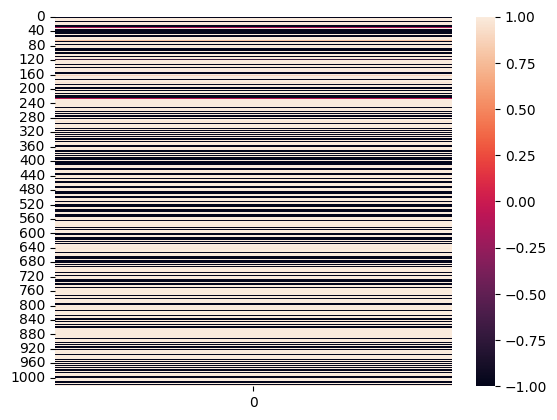

In [ ]:
import seaborn as sns
sns.heatmap(tanh_output)

In [ ]:
print(tanh_output)

tensor([[[-0.9999,  1.0000, -0.9990,  ...,  1.0000, -0.9990,  1.0000],
         [-1.0000,  1.0000,  0.7957,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0000,  1.0000,  0.9746,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-1.0000,  1.0000,  0.9770,  ...,  0.9948,  1.0000,  1.0000],
         [-1.0000,  1.0000,  0.9769,  ...,  0.9948,  1.0000,  1.0000],
         [-1.0000,  1.0000,  0.9769,  ...,  0.9948,  1.0000,  1.0000]],

        [[-0.9993,  1.0000, -0.9473,  ...,  1.0000, -0.9965,  0.9991],
         [-1.0000,  1.0000, -0.3317,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0000,  1.0000, -0.9999,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-1.0000,  1.0000,  0.9770,  ...,  0.9948,  1.0000,  1.0000],
         [-1.0000,  1.0000,  0.9769,  ...,  0.9947,  1.0000,  1.0000],
         [-1.0000,  1.0000,  0.9770,  ...,  0.9948,  1.0000,  1.0000]],

        [[-0.9993,  1.0000, -0.9800,  ...,  1.0000, -0.9942,  0.9998],
         [-1.0000,  1.0000,  0.9784,  ...,  1

# Learnings:

## Model RNN_v1:
RNN_v1 was just plain vanilla RNN with 3 layers + 1 Linear layer (logits calculation was here)
```
Architecture: 
  └── Embeddings()
  └── RNNLayer()
  └── RNNLayer()
  └── RNNLayer()
  └── Linear()
```
Problem: 
1. Generalization is not good because of Gradient vanishing | Solution: Added LayerNorm1D later with proper weight initialization and added Residual Skip connects for RNN_v2
2. Right now the model is forgetting the long term depencendies | Solution: Planning to add GRU and LSTM

---

## Model RNN_v2:
RNN_v2 was just plain vanilla RNN with 4 RNN layers with LayerNorm1D (3 RNN Layers + 1 RNN Layer (with logits calculation))
```
Architecture: 
  └── Embeddings()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
  └── LayerNorm1d()
  └── RNNLayer()
```

- Note:
we have to apply the LayerNorm1d() to RNNCell's forward pass also where the Residual skip-connection is applied

Problem: 
1. Generalization is good comparative to 'RNN_v1' because I solved Gradient vanishing by implementing LayerNorm1D later with proper weight initialization and added Residual Skip connects, but the Generalizations are not good Enough | Solution: Implement LSTM
2. Right now the model is forgetting the long term depencendies | Solution: Planning to add GRU and LSTM

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_loss_curve(diag, title="Training Loss Curve"):
    plt.figure(figsize=(7,5))
    plt.plot(diag.loss_curve)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def plot_activation_distribution(diag, idx=-1, title="Activations"):
    plt.figure(figsize=(7,5))
    sns.histplot(diag.activation_history[idx], bins=80, kde=True)
    plt.title(title)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()

def plot_gradient_flow(diag, title="Gradient Flow"):
    avg = [np.mean(g) for g in diag.grad_history]
    plt.figure(figsize=(7,5))
    plt.plot(avg)
    plt.title(title)
    plt.xlabel("Training Step")
    plt.ylabel("Mean Gradient Magnitude")
    plt.grid(True)
    plt.show()

def plot_weight_distribution(diag, idx=-1, title="Weight Distribution"):
    plt.figure(figsize=(7,5))
    sns.histplot(diag.weight_snapshots[idx], bins=100, kde=True)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

def plot_entropy(diag, title="Prediction Entropy Over Time"):
    plt.figure(figsize=(7,5))
    plt.plot(diag.entropy_history)
    plt.title(title)
    plt.xlabel("Training Step")
    plt.ylabel("Entropy")
    plt.grid(True)
    plt.show()

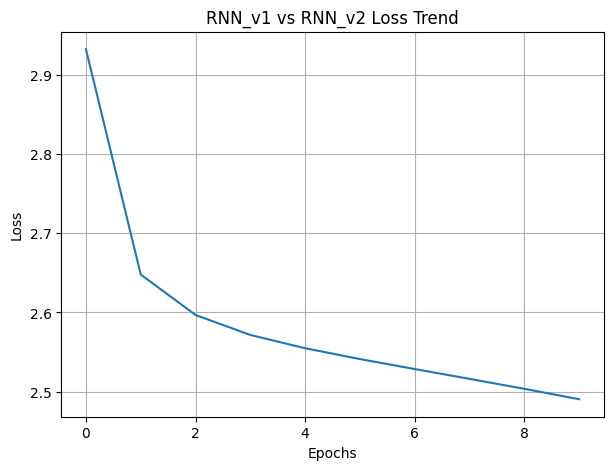

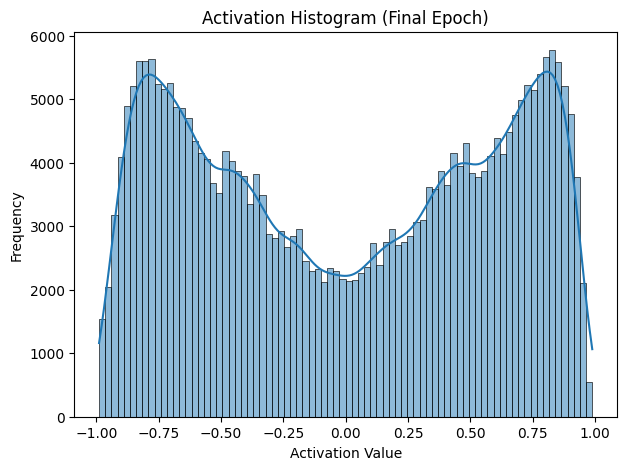

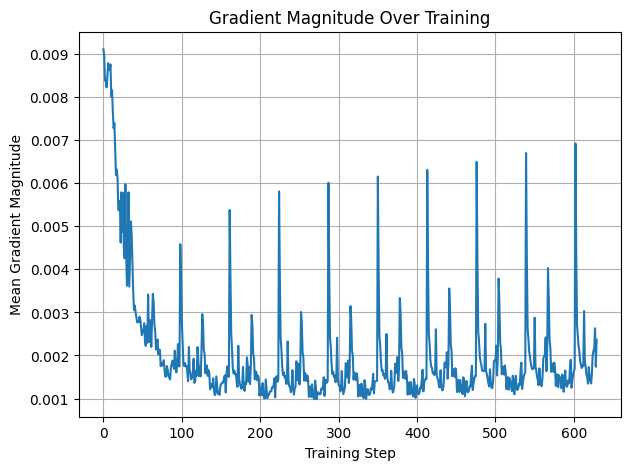

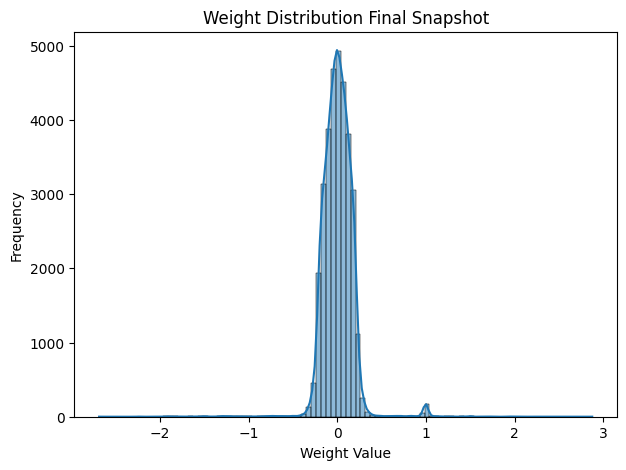

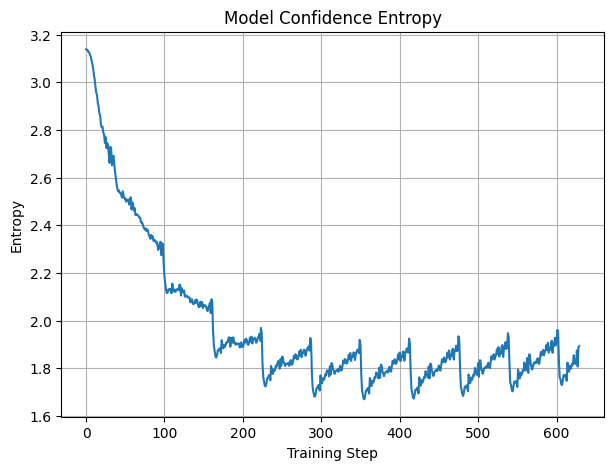

In [ ]:
plot_loss_curve(diag, "RNN_v1 vs RNN_v2 Loss Trend")
plot_activation_distribution(diag, title="Activation Histogram (Final Epoch)")
plot_gradient_flow(diag, title="Gradient Magnitude Over Training")
plot_weight_distribution(diag, title="Weight Distribution Final Snapshot")
plot_entropy(diag, title="Model Confidence Entropy")